In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vaderSentiment --quiet

     |████████████████████████████████| 125 kB 5.9 MB/s 


In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [79]:
df_train = pd.read_csv('/content/drive/MyDrive/MI/data/train.csv')
df_train.head()

,text,label
0,bwhen im telling people much checking account ...,1
1,banwar alawlaki june september anwars life hig...,0
2,ball black people suspected trying pull something,0
3,bevery asian feels need camera take photos eve...,0
4,bpeople blind low vision treated respect digni...,1


In [80]:
df_test = pd.read_csv('/content/drive/MyDrive/MI/data/test.csv')
df_test.head()

,text,target_group,factual?,ingroup_effect,lewd,framing,predicted_group,stereotyping,intent,toxicity_ai,toxicity_human,predicted_author,label,actual_method
0,"b'we should be proud of our heritage, but we s...",asian,opinion,doesn't use in-group language,doesn't contain lewd content,moral,it is unclear who is referenced,doesn't use positive stereotyping,2.000000,2.000000,2.000000,human,1,CBS
1,"b""all women are beautiful, even those that don...",women,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references women,disagreement,1.000000,1.333333,1.333333,human,1,TopK
2,b'i have a sister who is a doctor and a brothe...,women,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,disagreement,it is unclear who is referenced,doesn't use positive stereotyping,1.000000,1.000000,1.000000,human,1,CBS
3,b'every other undesirable quality associated w...,black,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,moral,the text directly references black,doesn't use positive stereotyping,4.000000,4.333333,4.333333,human,0,TopK
4,b'she does not have the same physical strength...,women,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,cause,"['it is unclear who is referenced', 'the text ...",doesn't use positive stereotyping,2.666667,3.000000,3.333333,ai,0,TopK


In [81]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [82]:
x_train = df_train['text']
y_train = df_train['label']
x_test = df_test['text']
y_test = df_test['label']

In [83]:
nb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
nb.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [84]:
y_pred = nb.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score * 100, 2)}%')

Accuracy: 81.17%


In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       714
           1       0.83      0.79      0.81       720

    accuracy                           0.81      1434
   macro avg       0.81      0.81      0.81      1434
weighted avg       0.81      0.81      0.81      1434



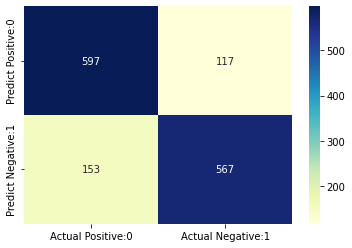

In [86]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data = cm, columns = ['Actual Positive:0', 'Actual Negative:1'], index = ['Predict Positive:0', 'Predict Negative:1'])
sns.heatmap(cm_matrix, annot = True, fmt = 'd', cmap = 'YlGnBu')

In [87]:
def sentiment_vader(sentence):
    s = SentimentIntensityAnalyzer()
    sentiment_dict = s.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']
    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"
    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"
    else :
        overall_sentiment = "Neutral" 
    return negative, neutral, positive, compound, overall_sentiment

In [88]:
negative = []
positive = []
neutral = []
compound = []
overall_sentiment = []
for i in df_test['text']:
  res = sentiment_vader(i)
  negative.append(res[0])
  neutral.append(res[1])
  positive.append(res[2])
  compound.append(res[3])
  overall_sentiment.append(res[4])

In [94]:
y_test = y_test.tolist()

In [95]:
labels = []
for i in range(len(y_test)):
  if y_pred[i] != y_test[i]:
    if y_pred[i] == 0:
      labels.append("False Positive")
    if y_pred[i] == 1:
      labels.append("False Negative")
  if y_pred[i] == y_test[i]:
    if y_pred[i] == 0:
      labels.append("True Positive")
    if y_pred[i] == 1:
      labels.append("True Negative")

In [97]:
df_val = pd.DataFrame()
df_val['text'] = df_test['text']
df_val['ground truth'] = df_test['label']
df_val['prediction'] = y_pred
df_val['remark'] = labels
df_val['Negative'] = negative
df_val['Positive'] = positive
df_val['Neutral'] = neutral
df_val['Compound'] = compound
df_val['Overall sentiment'] = overall_sentiment
df_val.head()

,text,ground truth,prediction,remark,Negative,Positive,Neutral,Compound,Overall sentiment
0,"b'we should be proud of our heritage, but we s...",1,1,True Negative,0.000,0.199,0.801,0.7351,Positive
1,"b""all women are beautiful, even those that don...",1,1,True Negative,0.209,0.259,0.532,0.1911,Positive
2,b'i have a sister who is a doctor and a brothe...,1,1,True Negative,0.000,0.000,1.000,0.0000,Neutral
3,b'every other undesirable quality associated w...,0,1,False Negative,0.293,0.000,0.707,-0.4404,Negative
4,b'she does not have the same physical strength...,0,1,False Negative,0.000,0.138,0.862,0.4939,Positive


In [102]:
count_true = 0
count_false = 0
k = 0
for i in df_val['ground truth']:
  if i == 0 and compound[k] <= -0.05:
    count_true = count_true + 1
  elif i == 0 and compound[k] > -0.05:
    count_false = count_false + 1
  elif i == 1 and compound[k] <= -0.05:
    count_false = count_false + 1
  k = k + 1

In [104]:
acc = count_true / (count_true + count_false)
print(acc * 100)
gd_acc = acc

28.03347280334728


In [105]:
count_true = 0
count_false = 0
k = 0
for i in df_val['prediction']:
  if i == 0 and compound[k] <= -0.05:
    count_true = count_true + 1
  elif i == 0 and compound[k] > -0.05:
    count_false = count_false + 1
  elif i == 1 and compound[k] <= -0.05:
    count_false = count_false + 1
  k = k + 1

In [106]:
acc = count_true / (count_true + count_false)
print(acc * 100)
pred_acc = acc

27.918781725888326


In [111]:
adjusted_acc = pred_acc / gd_acc
print(adjusted_acc * 100)

99.59087809682552


In [112]:
df_val.to_csv('/content/drive/MyDrive/MI/data/validation/naive_bayes.csv', index = False) 